In [2]:
import math
import matplotlib.pyplot as plt

def plot_nested_sensitivity_bars(
    stats_data,
    stats_order=None,
    title="Sensitivity metrics (nested bar chart)",
    y_label="Value",
    figsize=(14, 7),
    abbreviations=None,
    value_format=None,   # callable: float -> str  (e.g., lambda v: f"{v:.1f}" or f"{v*100:.0f}%")
    bar_alpha=0.85,
    annotate_rotation=45,
    scenario_label_rotation=45,
    scenario_spacing=0.06,
    bar_width=0.12,
    bottom_margin_for_labels=0.12
):
    """
    Create a nested bar chart where:
      • X groups = statistics (flexible list/order).
      • Within each statistic, 3 scenario subgroups: POINT, SOIL, POINT+SOIL (fixed).
      • Within each scenario, 2 bars = TP (blue) and TKN (orange) (fixed).
      • Scenario labels are tilted and shown beneath each subgroup.
      • Numeric value is printed above each bar, tilted.

    Required input structure (strict):
    stats_data: dict with EXACT keys and nesting:
      {
        "metrics": {
            "<STAT_1>": {
                "POINT": {"TP": <float>, "TKN": <float>},
                "SOIL":  {"TP": <float>, "TKN": <float>},
                "POINT+SOIL": {"TP": <float>, "TKN": <float>}
            },
            "<STAT_2>": { ... },
            ...
        }
      }

    Constraints:
      • All listed stats must include all three scenarios and both variables.
      • Values are numeric (float). If you pass fractions in [0,1], supply value_format to show as %.
      • stats_order (optional) is a list of stat names to control display order; if None, uses dict order.

    Abbreviations (optional):
      abbreviations: dict mapping scenario -> short label to draw under each subgroup.
        Default: {"POINT": "PNT", "SOIL": "SOL", "POINT+SOIL": "P+S"}

    value_format (optional):
      • A function to turn numbers into strings for the bar annotations.
      • If None, defaults to lambda v: f"{v:.1f}".
      • Example for percentages: value_format=lambda v: f"{v*100:.0f}%"

    Styling notes:
      • Variables are color-coded (TP = blue, TKN = orange) with a legend.
      • Scenario labels are placed below the x-axis, tilted.
      • Spacing and sizes can be tuned via function parameters.
    """
    # --- Fixed identities (as requested) ---
    scenarios = ["POINT", "SOIL", "POINT+SOIL"]
    variables = ["TP", "TKN"]

    # Defaults
    if abbreviations is None:
        abbreviations = {"POINT": "PNT", "SOIL": "SOL", "POINT+SOIL": "P+S"}
    if value_format is None:
        value_format = lambda v: f"{v:.1f}"

    metrics = stats_data.get("metrics", {})
    if not metrics:
        raise ValueError("stats_data must contain a non-empty 'metrics' dict.")

    # Validate presence of required keys for each stat
    def _validate_stat(stat_name, block):
        missing = []
        for sc in scenarios:
            if sc not in block:
                missing.append(f"scenario '{sc}'")
            else:
                for var in variables:
                    if var not in block[sc]:
                        missing.append(f"{sc}→'{var}'")
        if missing:
            raise ValueError(f"Metric '{stat_name}' is missing: {', '.join(missing)}")

    for s, block in metrics.items():
        _validate_stat(s, block)

    # Build the ordered list of statistics
    if stats_order is None:
        stats = list(metrics.keys())
    else:
        # ensure provided order is valid
        extra = [s for s in stats_order if s not in metrics]
        if extra:
            raise ValueError(f"stats_order contains stats not present in metrics: {extra}")
        stats = list(stats_order)

    # --- Layout math ---
    n_stats = len(stats)
    bars_per_subgroup = len(variables)                 # 2
    subgroup_width = bars_per_subgroup * bar_width     # width occupied by TP & TKN
    group_inner = len(scenarios) * subgroup_width + (len(scenarios) - 1) * scenario_spacing
    group_width = group_inner + 0.35                   # extra padding between statistic groups

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # color palette for variables (kept simple and conventional)
    var_to_color = {"TP": "#1f77b4", "TKN": "#ff7f0e"}

    # Find global y max for annotation offset
    global_max = -math.inf

    for i, stat in enumerate(stats):
        block = metrics[stat]
        for j, scenario in enumerate(scenarios):
            # Left edge of this subgroup
            subgroup_left = i * group_width + j * (subgroup_width + scenario_spacing)

            # Bars for TP and TKN
            for k, var in enumerate(variables):
                x = subgroup_left + k * bar_width
                y = float(block[scenario][var])
                global_max = max(global_max, y)
                bar = ax.bar(x, y, width=bar_width, color=var_to_color[var], alpha=bar_alpha)
                # Annotation above bar (tilted)
                ax.text(x, y + (0.015 * max(1.0, global_max)), value_format(y),
                        ha="center", va="bottom", rotation=annotate_rotation, fontsize=8)

            # Scenario label centered under the subgroup
            subgroup_center = subgroup_left + (subgroup_width - bar_width) / 2
            ax.text(subgroup_center, -0.04 * max(1.0, global_max),
                    abbreviations.get(scenario, scenario),
                    ha="center", va="top", rotation=scenario_label_rotation, fontsize=8)

    # X ticks: one per statistic, centered across its whole group
    xticks = [i * group_width + group_inner / 2 for i in range(n_stats)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(stats, fontsize=10)

    ax.set_ylabel(y_label)
    ax.set_title(title)

    # Legend for variables
    handles = [plt.Rectangle((0, 0), 1, 1, color=var_to_color[v]) for v in variables]
    ax.legend(handles, variables, title="Variables", loc="upper left", bbox_to_anchor=(1.02, 1))

    # Extend y-limits to make room for annotations and bottom labels
    top_pad = 0.12 * max(1.0, global_max)
    bottom_pad = bottom_margin_for_labels * max(1.0, global_max)
    ax.set_ylim(bottom=-bottom_pad, top=global_max + top_pad)

    # Clean gridlines for readability (horizontal only, light)
    ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
    ax.set_axisbelow(True)

    plt.tight_layout()
    return fig, ax


In [10]:
# Per-metric display format (string templates) and short semantic labels (≤15 chars)
format_val = {
  # Envelope (spread)
  "median_W":           "{:.1f}",     # absolute width (units of variable)
  "p90_W":              "{:.1f}",
  "RW_med":             "{:.0%}",     # relative width (median)
  "RW_high":            "{:.0%}",     # on event days
  "RW_low":             "{:.0%}",
  "Peak_ratio":         "{:.2f}×",

  # Central shift (displacement)
  "CS_abs":             "{:.1f}",     # absolute shift
  "CS_rel":             "{:.1%}",     # relative shift
  "Signed_C_shift":     "{:+.1%}",    # signed relative shift

  # Coverage
  "Coverage_frac":      "{:.0%}",
  "Outside_upper":      "{:.0%}",
  "Outside_lower":      "{:.0%}",

  # Event contrast
  "Event_contrast":     "{:+.0%}",    # RW_high − RW_low (relative units)
  "Event_ratio":        "{:.2f}×",

  # Duration-curve signature
  "RA_5":               "{:.0%}",
  "RA_50":              "{:.0%}",
  "RA_95":              "{:.0%}",

  # Optional shift detail (from your table)
  "delta_mean":         "{:+.1f}",
  "median_delta":       "{:+.1f}",
  "median_delta_pct":   "{:+.0%}",
  "delta_min":          "{:+.1f}",
  "delta_max":          "{:+.1f}",

  # Alias/legacy keys (if used)
  "relative_width":     "{:.0%}",
  "relative_width_high":"{:.0%}",
  "relative_width_low": "{:.0%}",
  "relative_width_event_contrast": "{:+.0%}"
}

semantic_label = {
  # Envelope (spread)
  "median_W":           "Median width",
  "p90_W":              "P90 width",
  "RW_med":             "Rel width med",
  "RW_high":            "Rel width high",
  "RW_low":             "Rel width low",
  "Peak_ratio":         "Peak ratio",

  # Central shift (displacement)
  "CS_abs":             "Shift |abs|",
  "CS_rel":             "Shift rel",
  "Signed_C_shift":     "Shift signed",

  # Coverage
  "Coverage_frac":      "Coverage",
  "Outside_upper":      "Outside upper",
  "Outside_lower":      "Outside lower",

  # Event contrast
  "Event_contrast":     "Event contrast",
  "Event_ratio":        "Event ratio",

  # Duration-curve signature
  "RA_5":               "RA @5%",
  "RA_50":              "RA @50%",
  "RA_95":              "RA @95%",

  # Optional shift detail
  "delta_mean":         "Mean Δ",
  "median_delta":       "Median Δ",
  "median_delta_pct":   "Median Δ%",
  "delta_min":          "Min Δ",
  "delta_max":          "Max Δ",

  # Aliases
  "relative_width":     "Rel width",
  "relative_width_high":"Rel width high",
  "relative_width_low": "Rel width low",
  "relative_width_event_contrast": "Event contrast"
}


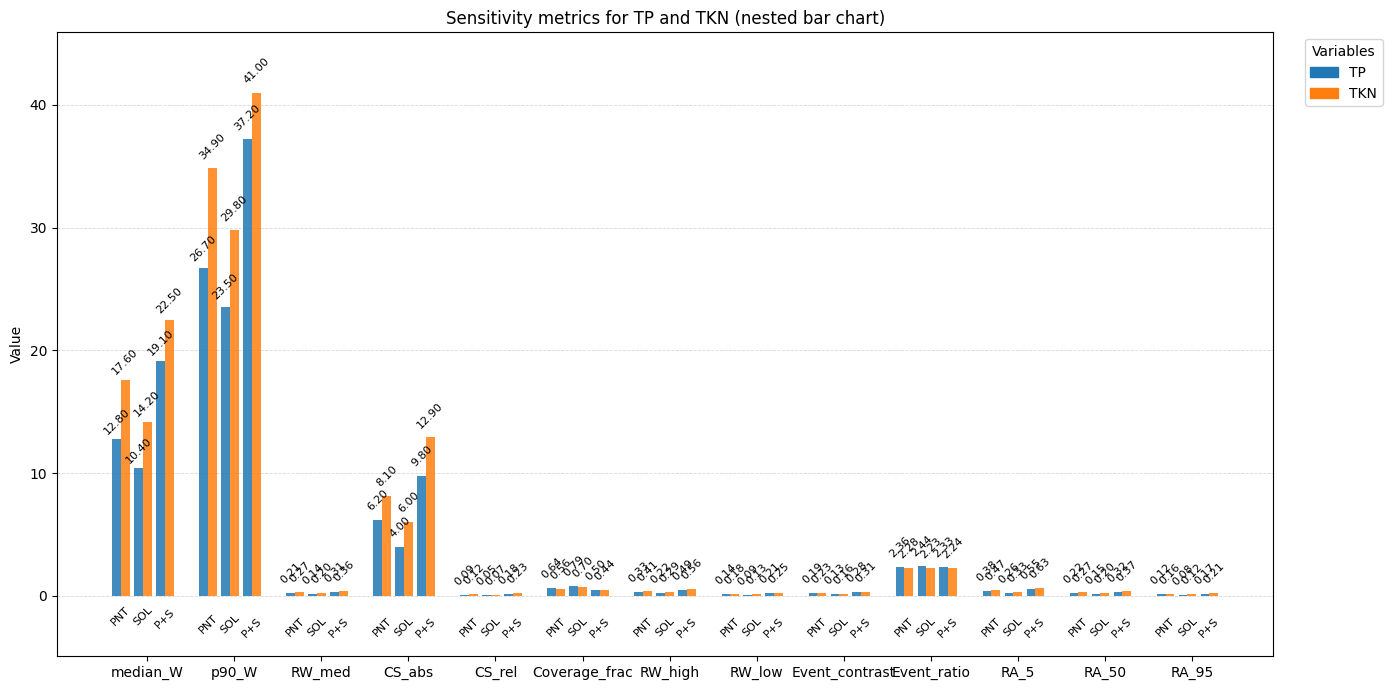

In [11]:
stats_data = {
  "metrics": {
    "median_W": {
      "POINT":      {"TP": 12.8, "TKN": 17.6},
      "SOIL":       {"TP": 10.4, "TKN": 14.2},
      "POINT+SOIL": {"TP": 19.1, "TKN": 22.5}
    },
    "p90_W": {
      "POINT":      {"TP": 26.7, "TKN": 34.9},
      "SOIL":       {"TP": 23.5, "TKN": 29.8},
      "POINT+SOIL": {"TP": 37.2, "TKN": 41.0}
    },
    "RW_med": {
      "POINT":      {"TP": 0.21, "TKN": 0.27},
      "SOIL":       {"TP": 0.14, "TKN": 0.20},
      "POINT+SOIL": {"TP": 0.31, "TKN": 0.36}
    },
    "CS_abs": {
      "POINT":      {"TP": 6.2,  "TKN": 8.1},
      "SOIL":       {"TP": 4.0,  "TKN": 6.0},
      "POINT+SOIL": {"TP": 9.8,  "TKN": 12.9}
    },
    "CS_rel": {
      "POINT":      {"TP": 0.09, "TKN": 0.12},
      "SOIL":       {"TP": 0.05, "TKN": 0.07},
      "POINT+SOIL": {"TP": 0.18, "TKN": 0.23}
    },
    "Coverage_frac": {
      "POINT":      {"TP": 0.64, "TKN": 0.56},
      "SOIL":       {"TP": 0.79, "TKN": 0.70},
      "POINT+SOIL": {"TP": 0.50, "TKN": 0.44}
    },
    "RW_high": {
      "POINT":      {"TP": 0.33, "TKN": 0.41},
      "SOIL":       {"TP": 0.22, "TKN": 0.29},
      "POINT+SOIL": {"TP": 0.49, "TKN": 0.56}
    },
    "RW_low": {
      "POINT":      {"TP": 0.14, "TKN": 0.18},
      "SOIL":       {"TP": 0.09, "TKN": 0.13},
      "POINT+SOIL": {"TP": 0.21, "TKN": 0.25}
    },
    "Event_contrast": {  # RW_high − RW_low
      "POINT":      {"TP": 0.19, "TKN": 0.23},
      "SOIL":       {"TP": 0.13, "TKN": 0.16},
      "POINT+SOIL": {"TP": 0.28, "TKN": 0.31}
    },
    "Event_ratio": {     # RW_high / RW_low
      "POINT":      {"TP": 2.36, "TKN": 2.28},
      "SOIL":       {"TP": 2.44, "TKN": 2.23},
      "POINT+SOIL": {"TP": 2.33, "TKN": 2.24}
    },
    "RA_5": {
      "POINT":      {"TP": 0.38, "TKN": 0.47},
      "SOIL":       {"TP": 0.26, "TKN": 0.33},
      "POINT+SOIL": {"TP": 0.55, "TKN": 0.63}
    },
    "RA_50": {
      "POINT":      {"TP": 0.22, "TKN": 0.27},
      "SOIL":       {"TP": 0.15, "TKN": 0.20},
      "POINT+SOIL": {"TP": 0.32, "TKN": 0.37}
    },
    "RA_95": {
      "POINT":      {"TP": 0.12, "TKN": 0.16},
      "SOIL":       {"TP": 0.08, "TKN": 0.12},
      "POINT+SOIL": {"TP": 0.17, "TKN": 0.21}
    }
  }
}

# Optional: display names to use under statistic groups (≤15 chars)
stat_display_names = {k: semantic_label.get(k, k) for k in stats_data["metrics"].keys()}

# Formats to apply per metric (used by your annotation/formatter layer)
format_per_metric = {k: format_val[k] for k in stats_data["metrics"].keys()}
fig, ax = plot_nested_sensitivity_bars(
    stats_data,
    stats_order=list(stats_data["metrics"].keys()),  # specify order if desired
    title="Sensitivity metrics for TP and TKN (nested bar chart)",
    y_label="Value",
    figsize=(14, 7),
    abbreviations={"POINT": "PNT", "SOIL": "SOL", "POINT+SOIL": "P+S"},
    value_format=lambda v: f"{v:.2f}",  # default formatting; can customize per metric if needed
    bar_alpha=0.85,
    annotate_rotation=45,
    scenario_label_rotation=45,
    scenario_spacing=0.06,
    bar_width=0.12,
    bottom_margin_for_labels=0.12
)

In [ ]:
metric_label_map = {
    # Group 1: Width & spread
    "median_W": "Model raw width median (W)",
    "p90_W": "Model raw width p90 (W)",
    "relative_W": "Model relative width (min-max / median)",
    "event_W": "Relative width (event days)",
    "non_event_W": "Relative width (non-event days)",

    # Group 2: Shift & coverage
    "coverage_fraction": "Coverage fraction (overlay inside envelope)",
    "delta_mean": "Mean shift (baseline - overlay)",
    "delta_min": "Shift in min (baseline - overlay)",
    "delta_p50": "Shift in p50 (baseline - overlay)",
    "delta_p90": "Shift in p90 (baseline - overlay)",
    "delta_max": "Shift in max (baseline - overlay)",
    "shift_event_pairs": "Shift event pairs (mean)",
    "shift_non_event_pairs": "Shift non-event pairs (mean)",
    "shift_normalized_mean": "Normalized mean shift (delta / baseline mean)"

    # Group 3: Event contrast (if used)

    #"relative_width_event_contrast": "Event contrast (high / low)",     
    #"event_ratio": "Event ratio (event / non-event)",
    #"relative_width_high": "Relative width high decile",
    #"relative_width_low": "Relative width low decile",
}


In [ ]:
    #("relative_width_event_contrast", "event_ratio", "relative_width_high", "relative_width_low"): [
    #    "Event contrast (high / low)",
    #   "Event ratio (event / non-event)",
    #    "Relative width high decile",
    #    "Relative width low decile",
    ],

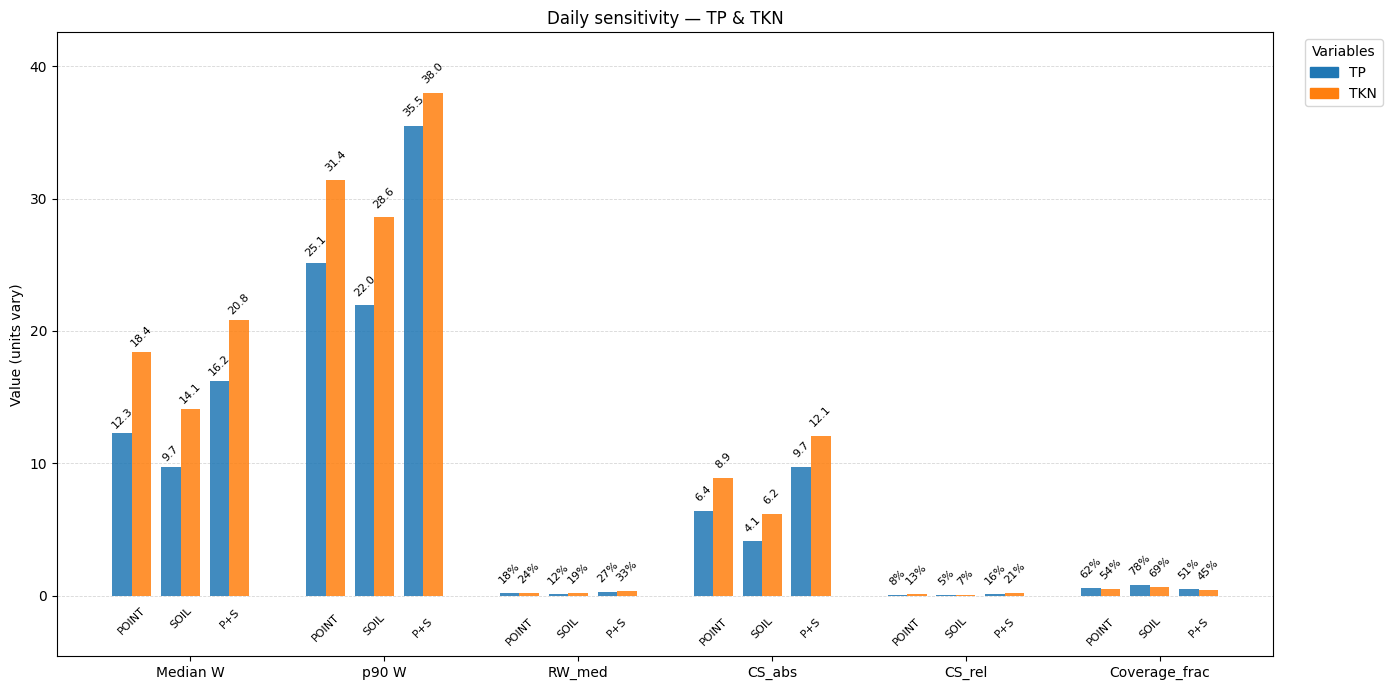

In [8]:
example = {
  "metrics": {
    "Median W": {
      "POINT":      {"TP": 12.3, "TKN": 18.4},
      "SOIL":       {"TP": 9.7,  "TKN": 14.1},
      "POINT+SOIL": {"TP": 16.2, "TKN": 20.8}
    },
    "p90 W": {
      "POINT":      {"TP": 25.1, "TKN": 31.4},
      "SOIL":       {"TP": 22.0, "TKN": 28.6},
      "POINT+SOIL": {"TP": 35.5, "TKN": 38.0}
    },
    "RW_med": {
      "POINT":      {"TP": 0.18, "TKN": 0.24},
      "SOIL":       {"TP": 0.12, "TKN": 0.19},
      "POINT+SOIL": {"TP": 0.27, "TKN": 0.33}
    },
    "CS_abs": {
      "POINT":      {"TP": 6.4, "TKN": 8.9},
      "SOIL":       {"TP": 4.1, "TKN": 6.2},
      "POINT+SOIL": {"TP": 9.7, "TKN": 12.1}
    },
    "CS_rel": {
      "POINT":      {"TP": 0.08, "TKN": 0.13},
      "SOIL":       {"TP": 0.05, "TKN": 0.07},
      "POINT+SOIL": {"TP": 0.16, "TKN": 0.21}
    },
    "Coverage_frac": {
      "POINT":      {"TP": 0.62, "TKN": 0.54},
      "SOIL":       {"TP": 0.78, "TKN": 0.69},
      "POINT+SOIL": {"TP": 0.51, "TKN": 0.45}
    }
  }
}




# Example call:
fig, ax = plot_nested_sensitivity_bars(
    example,
    abbreviations = {"POINT": "POINT", "SOIL": "SOIL", "POINT+SOIL": "P+S"},
    stats_order=["Median W","p90 W","RW_med","CS_abs","CS_rel","Coverage_frac"],
    title="Daily sensitivity — TP & TKN",
    y_label="Value (units vary)",
    value_format=lambda v: f"{v:.1f}" if v > 1 else f"{v*100:.0f}%",  # mix formatting
)
plt.show()

In [ ]:
Input spec 

Goal: Provide a JSON-like Python dict for stats_data to drive the chart. Statistics are flexible; scenarios and variables are fixed by the function.

Required structure:

{
  "metrics": {
    "<STAT_NAME_1>": {
      "POINT":      { "TP": <float>, "TKN": <float> },
      "SOIL":       { "TP": <float>, "TKN": <float> },
      "POINT+SOIL": { "TP": <float>, "TKN": <float> }
    },
    "<STAT_NAME_2>": {
      "POINT":      { "TP": <float>, "TKN": <float> },
      "SOIL":       { "TP": <float>, "TKN": <float> },
      "POINT+SOIL": { "TP": <float>, "TKN": <float> }
    }
    // ... more statistics as needed
  }
}


Rules:

Statistics (the top-level keys inside "metrics") can be any strings (e.g., "Median W", "p90 W", "RW_med", "CS_abs", "CS_rel", "Coverage_frac", "RA_5", "RA_50", "RA_95").

Every statistic must include all three scenarios ("POINT", "SOIL", "POINT+SOIL") and within each scenario both variables ("TP", "TKN").

All values are numeric (float). If values are given as fractions in [0,1] and should be displayed as percentages, the caller should set value_format=lambda v: f"{v*100:.0f}%".

Optional ordering: pass stats_order=["Median W","p90 W","RW_med","CS_abs","CS_rel","Coverage_frac"] to control the display sequence.

Minimal working example to pass the function:

